In [1]:
import random
import numpy as np
from scipy.spatial import Delaunay
from scipy.spatial.distance import pdist
from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from scipy.stats import gaussian_kde
from scipy.stats import gamma
from scipy.stats import truncnorm
from scipy.stats import truncexpon
from scipy.stats import expon
from scipy.stats import bernoulli
from scipy.stats import dirichlet
from matplotlib.colors import hsv_to_rgb
from matplotlib import colors as mcolors
from sklearn.metrics import pairwise_distances
from PIL import Image
import umap
import pickle as pkl
import seaborn as sns
import pandas as pd
import networkx as nx
import sys
import os
import scipy
import matplotlib.pyplot as plt

## Helper Functions

In [2]:
def generate_2d_points(N, dist_min):
    p = np.zeros((N, 2))
    p[0] = np.random.rand(2)
    for n in range(1, N):
        while True:
            p_n = np.random.rand(1, 2)
            D = cdist(p[0:n], p_n)
            if np.min(D) > dist_min:
                p[n] = p_n
                break
    return p

def generate_synthetic_cortex_metagenes(Ks, lambdas, ps, G=100, normalize='sum2one'):
    cKs = np.cumsum([0] + Ks.tolist())
    M = cKs[-1]
    for i, j, p, lam in zip(cKs[:-1], cKs[1:], ps, lambdas):
        m = gamma.rvs(lam, size=G)
        M[i] = m
        for k in range(i+1, j):
            mask = bernoulli.rvs(p, size=G).astype('bool')
            M[k, mask] = gamma.rvs(lam, size=np.sum(mask))
    M = M.T
    
    if normalize is None: pass
    elif normalize == 'sum2one': M /= np.sum(M, axis=0)
        
    return M

def generate_synthetic_cortex_replicate(points, sigX_scale=1.0, n_noise_metagenes=3):
    assert isinstance(n_noise_metagenes, int)
    K = 10 + n_noise_metagenes
    N = points.shape[0]
    cell_type = np.zeros((N), dtype='int')
    
    sigX_list = [.1, .1, .1, .1, .1,
                 .1, .1, .1, .1, .1] + ([.03] * n_noise_metagenes)
    sigX = np.array(sigX_list)
    sigX = sigX * sigX_scale
    
    Z = np.zeros((N, K))
    X = np.zeros((N, K))

    # Data consists of 4 layers of widths [.3, .2, .25, .25]. Each layer has a
    # unique excitatory neuronal type. There are three inhibitory neuronal
    # types which have slight layer preferences. There are two layer-specific
    # non-neuron types, one of which constitutes most of layer 2. There is a
    # third non-neuron type, which is uniformly distributed throughout.
    # 0 - Ex L1
    # 1 - Ex L2
    # 2 - Ex L3
    # 3 - Ex L4
    # 4 - In 1
    # 5 - In 2
    # 6 - non-Neuron L1
    # 7 - non-Neuron (ubiquitous)

    # Metagenes
    # 0 - Ex
    # 1 - In
    # 2 - In-1
    # 3 - In-2
    # 4 - non-Neuron 1
    # 5 - non-Neuron 2
    # 6 - L1
    # 7 - L2
    # 8 - L3
    # 9 - L4
    # 10 - end - random

    # Non-neuron 1
    ind = list(range(N))
    random.shuffle(ind)
    N_ind = int(len(ind)*.07)
    cell_type[ind[:N_ind]] = 7
    Z[ind[:N_ind], 4] = 1.0
    indL = np.where((points[:, 0] < .35) * (cell_type == 7))[0]
    Z[indL, 6] = 0.3
    indL = np.where(((points[:, 0] >= .35) * (points[:, 0] < .5)) * (cell_type == 7))[0]
    Z[indL, 7] = 0.3
    indL = np.where(((points[:, 0] >= .5) * (points[:, 0] < .75)) * (cell_type == 7))[0]
    Z[indL, 8] = 0.3
    indL = np.where((points[:, 0] >= .75) * (cell_type == 7))[0]
    Z[indL, 9] = 0.3

    # Layer 1
    indL = np.where((points[:, 0] < .35) * (cell_type == 0))[0]
    random.shuffle(indL)
    n_type1 = int(len(indL)*.1)
    n_type2 = n_type1 + int(len(indL)*.5)
    # Inhibitory 1
    cell_type[indL[:n_type1]] = 4
    Z[indL[:n_type1], 1] = 1.0
    Z[indL[:n_type1], 2] = 0.6
    Z[indL[:n_type1], 6] = 0.3
    # Non-Neuron 2
    cell_type[indL[n_type1:n_type2]] = 6
    Z[indL[n_type1:n_type2], 5] = 1.0
    Z[indL[n_type1:n_type2], 6] = 0.3
    # Excitatory L1
    cell_type[indL[n_type2:]] = 0
    Z[indL[n_type2:], 0] = 1.0
    Z[indL[n_type2:], 6] = 0.6

    # Layer 2
    indL = np.where(((points[:, 0] >= .35) * (points[:, 0] < .5)) * (cell_type == 0))[0]
    # Excitatory L2
    cell_type[indL] = 1
    Z[indL, 0] = 1.0
    Z[indL, 7] = 0.6

    # Layer 3
    indL = np.where(((points[:, 0] >= .5) * (points[:, 0] < .75)) * (cell_type == 0))[0]
    random.shuffle(indL)
    n_type1 = int(len(indL)*.1)
    n_type2 = n_type1 + int(len(indL)*.3)
    # Inhibitory 1
    cell_type[indL[:n_type1]] = 4
    Z[indL[:n_type1], 1] = 1.0
    Z[indL[:n_type1], 2] = 0.6
    Z[indL[:n_type1], 8] = 0.3
    # Inhibitory 2
    cell_type[indL[n_type1:n_type2]] = 5
    Z[indL[n_type1:n_type2], 1] = 1.0
    Z[indL[n_type1:n_type2], 3] = 0.6
    Z[indL[n_type1:n_type2], 8] = 0.3
    # Excitatory L3
    cell_type[indL[n_type2:]] = 2
    Z[indL[n_type2:], 0] = 1.0
    Z[indL[n_type2:], 8] = 0.6

    # Layer 4
    indL = np.where((points[:, 0] >= .75) * (cell_type == 0))[0]
    random.shuffle(indL)
    n_type1 = int(len(indL)*.1)
    n_type2 = n_type1 + int(len(indL)*.1)
    # Inhibitory 1
    cell_type[indL[:n_type1]] = 4
    Z[indL[:n_type1], 1] = 1.0
    Z[indL[:n_type1], 2] = 0.6
    Z[indL[:n_type1], 9] = 0.3
    # Inhibitory 2
    cell_type[indL[n_type1:n_type2]] = 5
    Z[indL[n_type1:n_type2], 1] = 1.0
    Z[indL[n_type1:n_type2], 3] = 0.6
    Z[indL[n_type1:n_type2], 9] = 0.3
    # Excitatory L4
    cell_type[indL[n_type2:]] = 3
    Z[indL[n_type2:], 0] = 1.0
    Z[indL[n_type2:], 9] = 0.6

    # Extrinsic factors
    Z[:, 10:K] = 0.05
    
#     print(Z[np.unique(cell_type, return_index=True)[1]])
    print(Z[cell_type==6])

    #Z = Z.T / np.sum(Z.T, axis=0)
    #Z = 10 * Z.T
    #Z = 1./Z.T
    for n in range(N):
        for k in range(K):
            X[n, k] = sigX[k]*truncnorm.rvs(-Z[n, k]/sigX[k], 100) + Z[n, k]
    #     X[n] = sample_exponential_on_simplex(1, Z[n], 30)
    #     X[n] = dirichlet.rvs(Z[n])
    X = X * (Z > 0)
    X = X.T
    X = X / np.sum(X, axis=0)
    return X, cell_type


In [2]:
def sample_gaussian(Sig, m, N=1):
    K = Sig.shape[0]
    assert Sig.shape[0] == Sig.shape[1]
    assert len(m) == K
    # Box-Muller Method
    L = np.linalg.cholesky(Sig)
    n_z = K + (K % 2)
    x = np.zeros((n_z, N))
    n_samples = 0
    while True:
        n_valid = 0
        while True:
            z = 2*np.random.rand(2) - 1
            if (z[0]**2 + z[1]**2 <= 1):
                r = np.linalg.norm(z)
                x[n_valid, n_samples] = z[0]*np.sqrt(-2*np.log(r**2)/r**2)
                x[n_valid + 1, n_samples] = z[1]*np.sqrt(-2*np.log(r**2)/r**2)
                n_valid += 2
            if n_valid == n_z:
                n_samples += 1
                break
        if n_samples == N:
            break
    # if K is odd, there will be one extra sample, so throw it away
    x = x[0:K, :]
    x = np.dot(L, x) + np.expand_dims(m, -1)
    return np.squeeze(x)

def generate_2d_points(N, dist_min):
    p = np.zeros((N, 2))
    p[0] = np.random.rand(2)
    for n in range(1, N):
        while True:
            p_n = np.random.rand(1, 2)
            D = cdist(p[0:n], p_n)
            if np.min(D) > dist_min:
                p[n] = p_n
                break
    return p

def generate_affinity_mat(p, tau=1.0, delaunay=True):
    if delaunay:
        A = np.zeros((p.shape[0], p.shape[0]))
        D = Delaunay(p)
        for tri in D.simplices:
            A[tri[0], tri[1]] = 1
            A[tri[1], tri[2]] = 1
            A[tri[2], tri[0]] = 1
    else:
        disjoint_nodes = True
        while(disjoint_nodes):
            N = p.shape[0]
            # Construct graph
            D = squareform(pdist(p))
            A = D < tau
            Id = np.identity(N, dtype='bool')
            A = A * ~Id
            G = nx.from_numpy_matrix(A)
            if not nx.is_connected(G):
                # increase tau by 10% and repeat
                tau = 1.1*tau
                print('Graph is not connected, increasing tau to %s', tau)
            else:
                disjoint_nodes = False
    return A

def generate_synthetic_cortex_metagenes(lambda_m1=4.0, lambda_m2=8.0, G=100, n_noise_metagenes=3, normalize=True):
    assert isinstance(n_noise_metagenes, int)
    K = 10 + n_noise_metagenes
    M = np.zeros((K, G))

    # Neuron types
    m = gamma.rvs(lambda_m1, size=G)
    M[0] = m
    M[1] = m
    mask = bernoulli.rvs(0.25, size=G).astype('bool')
    M[1, mask] = gamma.rvs(lambda_m1, size=np.sum(mask))
    # Inhibitory subtypes
    m = gamma.rvs(lambda_m1, size=G)
    M[2] = m
    M[3] = m
    mask = bernoulli.rvs(0.25, size=G).astype('bool')
    M[3, mask] = gamma.rvs(lambda_m1, size=np.sum(mask))
    mask = bernoulli.rvs(0.25, size=G).astype('bool')
    # Non-neuron types
    m = gamma.rvs(lambda_m1, size=G)
    M[4] = m
    M[5] = m
    mask = bernoulli.rvs(0.25, size=G).astype('bool')
    M[5, mask] = gamma.rvs(lambda_m1, size=np.sum(mask))
    # Layers
    m = gamma.rvs(lambda_m1, size=G)
    M[6] = m
    M[7] = m
    mask = bernoulli.rvs(0.1, size=G).astype('bool')
    M[7, mask] = gamma.rvs(lambda_m1, size=np.sum(mask))
    M[8] = m
    mask = bernoulli.rvs(0.1, size=G).astype('bool')
    M[8, mask] = gamma.rvs(lambda_m1, size=np.sum(mask))
    M[9] = m
    mask = bernoulli.rvs(0.1, size=G).astype('bool')
    M[9, mask] = gamma.rvs(lambda_m1, size=np.sum(mask))
    # Random
    for i in range(10, K):
        M[i] = gamma.rvs(lambda_m2, size=G)

    M = M.T
    if normalize:
        M = M / np.sum(M, axis=0)
    return M

def generate_synthetic_cortex_replicate(points, sigX_scale=1.0, n_noise_metagenes=3):
    assert isinstance(n_noise_metagenes, int)
    K = 10 + n_noise_metagenes
    N = points.shape[0]
    cell_type = np.zeros((N), dtype='int')
    
    sigX_list = [.1, .1, .1, .1, .1,
                 .1, .1, .1, .1, .1] + ([.03] * n_noise_metagenes)
    sigX = np.array(sigX_list)
    sigX = sigX * sigX_scale
    
    Z = np.zeros((N, K))
    X = np.zeros((N, K))

    # Data consists of 4 layers of widths [.3, .2, .25, .25]. Each layer has a
    # unique excitatory neuronal type. There are three inhibitory neuronal
    # types which have slight layer preferences. There are two layer-specific
    # non-neuron types, one of which constitutes most of layer 2. There is a
    # third non-neuron type, which is uniformly distributed throughout.
    # 0 - Ex L1
    # 1 - Ex L2
    # 2 - Ex L3
    # 3 - Ex L4
    # 4 - In 1
    # 5 - In 2
    # 6 - non-Neuron L1
    # 7 - non-Neuron (ubiquitous)

    # Metagenes
    # 0 - Ex
    # 1 - In
    # 2 - In-1
    # 3 - In-2
    # 4 - non-Neuron 1
    # 5 - non-Neuron 2
    # 6 - L1
    # 7 - L2
    # 8 - L3
    # 9 - L4
    # 10 - end - random

    # Non-neuron 1
    ind = list(range(N))
    random.shuffle(ind)
    N_ind = int(len(ind)*.07)
    cell_type[ind[:N_ind]] = 7
    Z[ind[:N_ind], 4] = 1.0
    indL = np.where((points[:, 0] < .35) * (cell_type == 7))[0]
    Z[indL, 6] = 0.3
    indL = np.where(((points[:, 0] >= .35) * (points[:, 0] < .5)) * (cell_type == 7))[0]
    Z[indL, 7] = 0.3
    indL = np.where(((points[:, 0] >= .5) * (points[:, 0] < .75)) * (cell_type == 7))[0]
    Z[indL, 8] = 0.3
    indL = np.where((points[:, 0] >= .75) * (cell_type == 7))[0]
    Z[indL, 9] = 0.3

    # Layer 1
    indL = np.where((points[:, 0] < .35) * (cell_type == 0))[0]
    random.shuffle(indL)
    n_type1 = int(len(indL)*.1)
    n_type2 = n_type1 + int(len(indL)*.5)
    # Inhibitory 1
    cell_type[indL[:n_type1]] = 4
    Z[indL[:n_type1], 1] = 1.0
    Z[indL[:n_type1], 2] = 0.6
    Z[indL[:n_type1], 6] = 0.3
    # Non-Neuron 2
    cell_type[indL[n_type1:n_type2]] = 6
    Z[indL[n_type1:n_type2], 5] = 1.0
    Z[indL[n_type1:n_type2], 6] = 0.3
    # Excitatory L1
    cell_type[indL[n_type2:]] = 0
    Z[indL[n_type2:], 0] = 1.0
    Z[indL[n_type2:], 6] = 0.6

    # Layer 2
    indL = np.where(((points[:, 0] >= .35) * (points[:, 0] < .5)) * (cell_type == 0))[0]
    # Excitatory L2
    cell_type[indL] = 1
    Z[indL, 0] = 1.0
    Z[indL, 7] = 0.6

    # Layer 3
    indL = np.where(((points[:, 0] >= .5) * (points[:, 0] < .75)) * (cell_type == 0))[0]
    random.shuffle(indL)
    n_type1 = int(len(indL)*.1)
    n_type2 = n_type1 + int(len(indL)*.3)
    # Inhibitory 1
    cell_type[indL[:n_type1]] = 4
    Z[indL[:n_type1], 1] = 1.0
    Z[indL[:n_type1], 2] = 0.6
    Z[indL[:n_type1], 8] = 0.3
    # Inhibitory 2
    cell_type[indL[n_type1:n_type2]] = 5
    Z[indL[n_type1:n_type2], 1] = 1.0
    Z[indL[n_type1:n_type2], 3] = 0.6
    Z[indL[n_type1:n_type2], 8] = 0.3
    # Excitatory L3
    cell_type[indL[n_type2:]] = 2
    Z[indL[n_type2:], 0] = 1.0
    Z[indL[n_type2:], 8] = 0.6

    # Layer 4
    indL = np.where((points[:, 0] >= .75) * (cell_type == 0))[0]
    random.shuffle(indL)
    n_type1 = int(len(indL)*.1)
    n_type2 = n_type1 + int(len(indL)*.1)
    # Inhibitory 1
    cell_type[indL[:n_type1]] = 4
    Z[indL[:n_type1], 1] = 1.0
    Z[indL[:n_type1], 2] = 0.6
    Z[indL[:n_type1], 9] = 0.3
    # Inhibitory 2
    cell_type[indL[n_type1:n_type2]] = 5
    Z[indL[n_type1:n_type2], 1] = 1.0
    Z[indL[n_type1:n_type2], 3] = 0.6
    Z[indL[n_type1:n_type2], 9] = 0.3
    # Excitatory L4
    cell_type[indL[n_type2:]] = 3
    Z[indL[n_type2:], 0] = 1.0
    Z[indL[n_type2:], 9] = 0.6

    # Extrinsic factors
    Z[:, 10:K] = 0.05

    #Z = Z.T / np.sum(Z.T, axis=0)
    #Z = 10 * Z.T
    #Z = 1./Z.T
    for n in range(N):
        for k in range(K):
            X[n, k] = sigX[k]*truncnorm.rvs(-Z[n, k]/sigX[k], 100) + Z[n, k]
    #     X[n] = sample_exponential_on_simplex(1, Z[n], 30)
    #     X[n] = dirichlet.rvs(Z[n])
    X = X * (Z > 0)
    X = X.T
    X = X / np.sum(X, axis=0)
    return X, cell_type

def perturb_genes(Y, K, g1=.2, g2=.2, shape=2.5):
    G, N = Y.shape
    G_g = int(g1*G)
    for n in range(N):
        ind = random.sample(range(G), G_g)
        Y[ind, n] = gamma.rvs(shape, size=G_g) / float(G)
    G_g = int(g2*G)
    ind = random.sample(range(G), G_g)
    Y[ind, :] = (gamma.rvs(shape, size=(G_g*N)) / float(G)).reshape((G_g, N))
    return Y


## Plotting Functions

In [3]:
def drawEdges(p, A, color='gray', linewidth=1):
    for i, e in enumerate(D.A[0]):
        for j, ee in enumerate(e):
            if ee:
                plt.plot([p[i, 0], p[j, 0]], [p[i, 1], p[j, 1]], color=color, linewidth=linewidth)

def plot_UMAP(X, C, plots_dir, colors=None, save_figure=False, normalize=True):
    if not colors:
        colors = {0: 'darkkhaki', 1: 'mediumspringgreen', 2: 'greenyellow', 3: '#95bfa6',
                  4: 'violet', 5: 'firebrick', 6: 'gold',
                  7: 'deepskyblue', 8: 'darkslateblue', 9: 'gainsboro'}
    if normalize:
        x = (X.T - np.average(X.T, axis=0))
        x_std = x.std(axis=0)
        for k in range(x.shape[1]):
            if not x_std[k] == 0:
                x[:,k] = np.divide(x[:,k], x_std[k])

    # UMAP
    X_u = umap.UMAP(
                    n_components=2,
                    #         spread=1,
                    n_neighbors=10,
                    min_dist=0.3,
                    #         learning_rate=100,
                    #         metric='euclidean',
                    #         metric='manhattan',
                    #         metric='canberra',
                    #         metric='braycurtis',
                    #         metric='mahalanobis',
                    #         metric='cosine',
                    #         metric='correlation',
                    ).fit_transform(x)

    fig = plt.figure(figsize=(7, 5))
    ax = fig.add_axes([0.1, 0.1, .8, .8])
    for c in np.unique(C):
        idx = C == c
        ax.scatter(X_u[idx, 0], X_u[idx, 1], alpha=.7, c=colors[c])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.yaxis.set_label_position('right')
    plt.show()
    if save_figure:
        plt.savefig(os.path.join(plots_dir, 'synth_umap.png'))

def plot_cell_types(p, C, A, colors=None):
    if not colors:
        colors = {0: 'sandybrown', 1: 'lightskyblue',
                  2: 'mediumspringgreen', 3: 'palegreen',
                  4: 'greenyellow', 5: 'darkseagreen',
                  6: 'burlywood', 7: 'orangered', 8: 'firebrick',
                  9: 'gold', 10: 'mediumorchid', 11: 'magenta',
                  12: 'palegoldenrod', 13: 'gainsboro', 14: 'teal',
                  15: 'darkslateblue'}
    df = pd.DataFrame({'X': p[:, 0], 'Y': p[:, 1], 'C': C})
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0, 0, 1, 1])
    drawEdges(p, A)
    sns.scatterplot(data=df, x='X', y='Y', hue='C', ax=ax, palette=colors,
                    legend=False, hue_order=list(set(C)), size_norm=10.0)
    plt.show()


def plot_metagene_expression(X, p, plots_dir, save_figure=False):
    K, N = X.shape
    for k in range(K):
        fig = plt.figure(figsize=(5, 3))
        ax = fig.add_axes([.1, .1, .8, .8])
        ax.set_ylabel('Metagene ' + str(k))
        sca = ax.scatter(p[:, 0], p[:, 1], c=X[k], s=23, cmap=plt.get_cmap('Blues'), vmin=0)
        #ax.xaxis.set_visible(False)
        fig.colorbar(sca)
        ax.set_yticks([])
        ax.set_xticks([])
        plt.show()
        if save_figure:
            plt.savefig(os.path.join(plots_dir, 'synth-metagene_' + str(k) + '.png'))

def plot_metagenes(M, order_genes=True):
    if order_genes:
        mclust = scipy.cluster.hierarchy.linkage(M, 'ward')
        mdendro = scipy.cluster.hierarchy.dendrogram(mclust, no_plot=True)
        plt.imshow(M[mdendro['leaves']], aspect='auto')
    else:
        plt.imshow(M, aspect='auto')
    plt.xlabel('Metagene ID')
    plt.ylabel('Gene ID')
    plt.show()

def plot_expression(Y, plots_dir, order_genes=True, C=None, save_figure=False):
    fig = plt.figure(figsize=(8, 8))
    if C is not None:
        indx = []
        for c in list(set(C)):
            indx += list(np.where(C == c)[0])
#        ax = fig.add_axes([0.1, 0.9, 0.8, 0.05])
#        #colors = [sp_colors[c] for c in C]
#        #colors = np.array(colors, dtype='object')
#        #ax.table(cellColours=np.expand_dims(C, -1))
#        #ax.table(cellColours=np.expand_dims(colors, -1))
#        colors = []
#        colors.append([sp_colors[c] for c in C])
#        colors.append([sp_colors[c] for c in C])
#        colors = []
#        colors.append([sp_colors[c] for c in range(10)])
#        colors.append([sp_colors[c] for c in range(10)])
#        ax.table(cellColours=colors, edges='open')
#        #ax.table(cellColours=colors, edges='open')
#        #ax.set_xticks([])
#        #ax.set_yticks([])
    else:
        indx = list(range(Y.shape[1]))
    if order_genes:
        yclust = scipy.cluster.hierarchy.linkage(Y, 'ward')
        ydendro = scipy.cluster.hierarchy.dendrogram(yclust, no_plot=True)
        indy = ydendro['leaves']
    else:
        indy = list(range(Y.shape[0]))
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.7])
    ax.imshow(Y[indy][:, indx], aspect='auto', zorder=10)
    ax.set_ylabel('Gene ID')
    ax.set_xlabel('Cell ID')
    plt.show()
    if save_figure:
        plt.savefig(os.path.join(plots_dir, 'synth_Y.png'))


def plot_membership(X, C=None):
    if C is not None:
        ind = []
        for c in list(set(C)):
            ind += list(np.where(C == c)[0])
        im = plt.imshow(X[:, ind], aspect='auto')
    else:
        plt.imshow(X, aspect='auto')
    plt.xlabel('Cell ID')
    plt.ylabel('Metagene ID')
    plt.colorbar(im)
    plt.show()


def plot_membership_distribution(X, C, plots_dir, save_figure=False):
    K, N = X.shape
    for c in np.unique(C):
        idx = c == C
        X_temp = X[:, idx].T
        print(np.average(X_temp, axis=0))
        Xdf = pd.DataFrame(X_temp)
        #fig = plt.figure(figsize=(8, 6))
        Xdf.plot.hist(bins=12, alpha=0.4)
        plt.show()
        if save_figure:
            plt.savefig(os.path.join(plots_dir, 'synth_X' + str(c) + '_dist.png'))


## Dataset Class and Functions

In [4]:
def reformat(X, Y, A, p, M, sig_yx, Sig_x_inv, gene_ind, n_replicates, data_dir):
    GG, K = M.shape

    gene_ind_exclu = sorted(list(set(range(GG)) - set(gene_ind)))
    gene_ind_share = list(gene_ind)
    gene_ind = gene_ind_share + gene_ind_exclu
    M = M[gene_ind]

    YTs = [y.T for y in Y]
    XTs = [x.T for x in X]
    Ns, Gs = zip(*[YT.shape for YT in YTs])

    sigma_yx_invs = [1./sig_yx for _ in XTs]
    delta_x = np.zeros(K)
    prior_xs = [('Exponential shared', np.ones(K), ) for _ in XTs]

    for G, YT, XT, prior_x in zip(Gs, YTs, XTs, prior_xs):
        assert prior_x[0] == 'Exponential shared'
        lambda_x, = prior_x[1:]
        lambda_x = lambda_x.mean()
        print('G = {}'.format(G))
        print('mean Xik = {} ~ {}'.format(XT.mean(), 1/lambda_x))
        print('mean Yig = {} ~ {}'.format(YT.mean(), K/lambda_x/GG))
        print('mean power Yig = {}'.format((YT**2).mean()))
        print('mean |Yi| = {} ~ {}'.format(YT.sum(1).mean(), K*G/lambda_x/GG))
        print('RMSE Y = {} ~ {}'.format(np.sqrt(((YT.T - M[:G] @ XT.T)**2).mean()), sig_yx))
        print('SNR = {}'.format((YT**2).mean() / sig_yx**2))
        print('SNR (dB) = {}'.format(10*np.log((YT**2).mean() / (2*sig_yx)**2)))

    n_replicates = len(Y)
    for i in range(n_replicates):
        np.savetxt(os.path.join(data_dir, 'files', 'expression_' + str(i) + '.txt'), Y[i].T, fmt='%.6f')
        np.savetxt(os.path.join(data_dir, 'files', 'coordinates_' + str(i) + '.txt'), p[i], fmt='%.6f')
        # np.savetxt('../files/coordinates_1.txt', p, fmt='%.6f')
        with open(os.path.join(data_dir, 'files', 'neighborhood_' + str(i) + '.txt'), 'w') as f:
            for i, e in enumerate(A[i]):
                for j, ee in enumerate(e):
                    if not ee: continue
                    f.write('{}\t{}\n'.format(i, j))

    for i in range(n_replicates):
        np.savetxt(os.path.join(data_dir, 'files', 'genes_' + str(i) + '.txt'), np.arange(len(Y[i])), fmt='%d')

    np.savetxt(os.path.join(data_dir, 'files', 'truth_M.txt'), M, fmt='%.6f')
    for i in range(n_replicates):
        np.savetxt(os.path.join(data_dir, 'files', 'truth_X_' + str(i) + '.txt'), X[i].T, fmt='%.6f')

    if not os.path.exists(os.path.join(data_dir, 'logs')):
        os.mkdir(os.path.join(data_dir, 'logs'))
    if not os.path.exists(os.path.join(data_dir, 'scripts')):
        os.mkdir(os.path.join(data_dir, 'scripts'))
    for iexprs in [range(r) for r in range(1, n_replicates+1)]:
        folder = os.path.join(data_dir, 'logs', '-'.join(map(str, iexprs)))
        os.makedirs(folder, exist_ok=True)
        g = max(Gs[_] for _ in iexprs)
        scaling = [G / g * K / YT.sum(1).mean() for G, YT in zip(Gs, YTs)]
        print(scaling)
        
        with open('{}/H_0.pkl'.format(folder), 'wb') as f:
            pkl.dump(
                (
                    [XTs[_] * scaling[_] * M[:g].sum(0) for _ in iexprs],
                ),
                f, protocol=2,
            )
        
        with open('{}/Theta_0.pkl'.format(folder), 'wb') as f:
            pkl.dump(
                (
                    M[:g] / M[:g].sum(0, keepdims=True),
                    [sigma_yx_invs[_]/scaling[_] for _ in iexprs],
                    Sig_x_inv,
                    delta_x,
                    [prior_xs[_] for _ in iexprs],
                ),
                f, protocol=2,
            )
        
        with open('{}/Q_0.pkl'.format(folder), 'wb') as f:
            pkl.dump(
                0.,
                f, protocol=2,
            )

class Dataset:
    def __init__(self, setting, dir_suffix=''):
        self.K = 10 + setting['n_noise_metagenes']
        self.N = setting['n_cells']
        self.colors = {0: 'darkkhaki', 1: 'mediumspringgreen', 2: 'greenyellow', 3: '#95bfa6',
                       4: 'violet', 5: 'firebrick',
                       6: 'deepskyblue', 7: 'darkslateblue'}
        print('Creating M...')
        self.M = generate_synthetic_cortex_metagenes(G=setting['n_genes'],
                                                lambda_m1=setting['lambda_m1'], lambda_m2=setting['lambda_m2'])
        print('Creating X, A, and p...')
        self.X = []
        self.p = []
        self.A = []
        self.C = []
        self.n_replicates = setting['n_replicates']
        dist_min = 0.75/np.sqrt(setting['n_cells'])
        tau = dist_min * 2.2
        for r in range(setting['n_replicates']):
            valid_A = False
            while not valid_A:
                p_temp = generate_2d_points(setting['n_cells'], dist_min)
                A_temp = generate_affinity_mat(p_temp, tau)
                try:
                    X_temp, C_temp = generate_synthetic_cortex_replicate(p_temp, sigX_scale=setting['sigX_scale'])
                    valid_A = True
                except ValueError as e:
                    print(e)
            self.S = gamma.rvs(self.K, scale=setting['lambda_s'], size=self.N)
            self.A.append(A_temp)
            self.p.append(p_temp)
            self.X.append(X_temp * self.S)
            self.C.append(C_temp)

        print('Creating Y...')
        self.sig_y = float(setting['sigY_scale'])/setting['n_genes']
        self.Y = []
        for r in range(setting['n_replicates']):
            self.Y.append(np.matmul(self.M, self.X[r]))
            Sig_y = (self.sig_y**2)*np.identity(setting['n_genes'])
            for i in range(self.N):
                self.Y[r][:, i] = sample_gaussian(Sig_y, self.Y[r][:, i])
            if setting['gene_replace_prob'] > 0 and setting['element_replace_prob'] > 0:
                self.Y[r] = perturb_genes(self.Y[r], self.K, g1=setting['gene_replace_prob'],
                                     g2=setting['element_replace_prob'], shape=self.K)
        # gene_ind variable is just all genes -- we don't remove any
        self.gene_ind = range(setting['n_genes'])
        # create empty Sig_x_inverse, since it is not used in this data generation
        self.Sig_x_inv = np.zeros((self.K, self.K))

        self.data_dir = os.path.join(data_dir_main, 'synthetic_' + str(setting['n_cells']) + '_' + str(setting['n_genes']) + \
                                     '_' + str(int(setting['sigY_scale']*10)) + '_' + str(int(setting['sigX_scale']*10)) + \
                                     '_' + str(int(setting['gene_replace_prob']*100)) + '_' + str(int(setting['element_replace_prob']*100)) + \
                                     '_' + dir_suffix)
        print('Finished')

    def init_data_dir(self):
        if not os.path.exists(self.data_dir):
            os.mkdir(self.data_dir)
        if not os.path.exists(os.path.join(self.data_dir, 'files')):
            os.mkdir(os.path.join(self.data_dir, 'files'))
        if not os.path.exists(os.path.join(self.data_dir, 'logs')):
            os.mkdir(os.path.join(self.data_dir, 'logs'))
        if not os.path.exists(os.path.join(self.data_dir, 'scripts')):
            os.mkdir(os.path.join(self.data_dir, 'scripts'))
        if not os.path.exists(os.path.join(self.data_dir, 'plots')):
            os.mkdir(os.path.join(self.data_dir, 'plots'))

    def save_pickle(self):
        self.init_data_dir()
        filename = 'synth.pkl'
        filename_full = os.path.join(self.data_dir, 'files', filename)
        f_out = open(filename_full, 'wb')
        pkl.dump([self.X, self.Y, self.A, self.p, self.M, self.sig_y, self.Sig_x_inv, self.gene_ind], f_out)
        f_out.close()
        filename_prefix = filename.split('.pkl')[0]
        filename_full = os.path.join(self.data_dir, 'files', filename_prefix + '-C.pkl')
        f_out_C = open(filename_full, 'wb')
        pkl.dump([self.C], f_out_C)
        f_out_C.close()

    def reformat(self):
        reformat(self.X, self.Y, self.A, self.p, self.M, self.sig_y, self.Sig_x_inv, self.gene_ind, self.n_replicates, self.data_dir)

    def plot_latent_space(self, replicate=0, cell_types=None, save_figure=False):
        if not cell_types:
            plot_UMAP(self.X[replicate], self.C[replicate], os.path.join(self.data_dir, 'plots'), self.colors, save_figure=False)
        else:
            X = self.X[replicate]
            C = self.C[replicate]
            ind = [C[i] in cell_types for i in range(len(C))]
            plot_UMAP(X[:, ind], C[ind], os.path.join(self.data_dir, 'plots'), self.colors, save_figure=False)

    def plot_expression_space(self, replicate=0, cell_types=None, save_figure=False):
        if not cell_types:
            plot_UMAP(self.Y[replicate], self.C[replicate], os.path.join(self.data_dir, 'plots'), self.colors, save_figure=False)
        else:
            Y = self.Y[replicate]
            C = self.C[replicate]
            ind = [C[i] in cell_types for i in range(len(C))]
            plot_UMAP(Y[:, ind], C[ind], os.path.join(self.data_dir, 'plots'), self.colors, save_figure=False)

    def plot_metagenes(self, save_figure=False):
        plot_metagenes(self.M, order_genes=True)

    def plot_expression(self, replicate=0, save_figure=False):
        plot_expression(self.Y[replicate], os.path.join(self.data_dir, 'plots'), order_genes=True, C=self.C[replicate], save_figure=False)

    def plot_cell_types(self, replicate=0, save_figure=False):
        plot_cell_types(self.p[replicate], self.C[replicate], self.colors)

    def plot_metagenes_in_situ(self, replicate=0, save_figure=False):
        plot_metagene_expression(self.X[replicate], self.p[replicate], os.path.join(self.data_dir, 'plots'), save_figure=False)

    def plot_hidden_states(self, replicate=0, save_figure=False):
        plot_membership(self.X[replicate], self.C[replicate])

## Main

In [13]:
# Create Datasets
save_dataset = True
# data_dir_main = '/media/data/ben/SpiceMix/data/synthetic_small/'
data_dir_main = '../data/'

n_instances = 20
settings = [{'n_cells': 500, 'n_genes': 100, 'n_replicates': 16,
             'sigX_scale': 3.0, 'sigY_scale': 2.0,
             'lambda_m1': 4.0, 'lambda_m2': 8.0, 'lambda_s': 1.0,
             'gene_replace_prob': 0.0, 'element_replace_prob': 0.0,
             'n_noise_metagenes': 3}]

synth_data = []
for setting in settings:
    for i in range(n_instances):
        D = Dataset(setting, dir_suffix=('i' + str(i)))
        synth_data.append(D)
        D.save_pickle()
        D.reformat()

Creating M...
Creating X, A, and p...
Creating Y...
Finished
G = 100
mean Xik = 0.9851733693178593 ~ 1.0
mean Yig = 0.12795267747744968 ~ 0.13
mean power Yig = 0.019898682199465105
mean |Yi| = 12.795267747744969 ~ 13.0
RMSE Y = 0.019969466426962332 ~ 0.02
SNR = 49.74670549866276
SNR (dB) = 25.206498791595884
G = 100
mean Xik = 0.9901376479214492 ~ 1.0
mean Yig = 0.12884959942540797 ~ 0.13
mean power Yig = 0.01994767055987446
mean |Yi| = 12.884959942540794 ~ 13.0
RMSE Y = 0.019861675911919566 ~ 0.02
SNR = 49.86917639968615
SNR (dB) = 25.23108743356633
G = 100
mean Xik = 1.0008195161298556 ~ 1.0
mean Yig = 0.1299589210288484 ~ 0.13
mean power Yig = 0.020452791777876005
mean |Yi| = 12.995892102884838 ~ 13.0
RMSE Y = 0.020011470643211054 ~ 0.02
SNR = 51.13197944469001
SNR (dB) = 25.48115761180993
G = 100
mean Xik = 1.0072283656534022 ~ 1.0
mean Yig = 0.13084037363689893 ~ 0.13
mean power Yig = 0.02073780238041253
mean |Yi| = 13.084037363689891 ~ 13.0
RMSE Y = 0.019880673811364907 ~ 0.02
SN

Creating M...
Creating X, A, and p...
Creating Y...
Finished
G = 100
mean Xik = 0.9941504650174681 ~ 1.0
mean Yig = 0.12930309622002822 ~ 0.13
mean power Yig = 0.02051640492476593
mean |Yi| = 12.930309622002824 ~ 13.0
RMSE Y = 0.019995063460707115 ~ 0.02
SNR = 51.29101231191482
SNR (dB) = 25.512211771096144
G = 100
mean Xik = 0.986170462896021 ~ 1.0
mean Yig = 0.12808911045046534 ~ 0.13
mean power Yig = 0.019908385167377998
mean |Yi| = 12.808911045046534 ~ 13.0
RMSE Y = 0.020036420152390877 ~ 0.02
SNR = 49.770962918444994
SNR (dB) = 25.211373789302016
G = 100
mean Xik = 1.0023231873423382 ~ 1.0
mean Yig = 0.13028224332807165 ~ 0.13
mean power Yig = 0.020627773316146732
mean |Yi| = 13.028224332807163 ~ 13.0
RMSE Y = 0.019865875672613685 ~ 0.02
SNR = 51.56943329036683
SNR (dB) = 25.566347577487356
G = 100
mean Xik = 1.005890332695729 ~ 1.0
mean Yig = 0.13060023335571944 ~ 0.13
mean power Yig = 0.020672615463069675
mean |Yi| = 13.060023335571945 ~ 13.0
RMSE Y = 0.020048516708608303 ~ 0.02

Creating M...
Creating X, A, and p...
Creating Y...
Finished
G = 100
mean Xik = 1.015456357112602 ~ 1.0
mean Yig = 0.13196715387736604 ~ 0.13
mean power Yig = 0.02122296420302888
mean |Yi| = 13.196715387736605 ~ 13.0
RMSE Y = 0.019983449521186004 ~ 0.02
SNR = 53.05741050757219
SNR (dB) = 25.850801832998897
G = 100
mean Xik = 0.9902288515898848 ~ 1.0
mean Yig = 0.1286537931501327 ~ 0.13
mean power Yig = 0.020107811422122673
mean |Yi| = 12.86537931501327 ~ 13.0
RMSE Y = 0.0200370304792769 ~ 0.02
SNR = 50.26952855530668
SNR (dB) = 25.31104738289308
G = 100
mean Xik = 1.0177961712003463 ~ 1.0
mean Yig = 0.1322716839282662 ~ 0.13
mean power Yig = 0.021027666620874543
mean |Yi| = 13.227168392826618 ~ 13.0
RMSE Y = 0.020011499084283773 ~ 0.02
SNR = 52.56916655218635
SNR (dB) = 25.75835399528082
G = 100
mean Xik = 0.9903698078969733 ~ 1.0
mean Yig = 0.1286793684870021 ~ 0.13
mean power Yig = 0.020121856201751335
mean |Yi| = 12.867936848700207 ~ 13.0
RMSE Y = 0.020098405960638954 ~ 0.02
SNR = 5

[0.9850936098902756, 1.0104637944743404, 0.9828256217748149, 1.0102629623421826, 0.9983824052999307, 1.0031022520228492, 1.0005215990105476, 1.0125589483919502, 1.0120384137451868, 1.0011743137438345, 1.0003558061510012, 1.0111793806283103, 1.0163522489638837, 1.0050942647659988, 0.9982922705766915, 0.9935676226045858]
Creating M...
Creating X, A, and p...
Creating Y...
Finished
G = 100
mean Xik = 1.0115265260040904 ~ 1.0
mean Yig = 0.1314429809033971 ~ 0.13
mean power Yig = 0.02121498552546459
mean |Yi| = 13.144298090339708 ~ 13.0
RMSE Y = 0.020003995411437842 ~ 0.02
SNR = 53.037463813661475
SNR (dB) = 25.847041671299596
G = 100
mean Xik = 0.9914474453452811 ~ 1.0
mean Yig = 0.1287874398063406 ~ 0.13
mean power Yig = 0.02054328766645995
mean |Yi| = 12.878743980634063 ~ 13.0
RMSE Y = 0.019987420657960286 ~ 0.02
SNR = 51.35821916614987
SNR (dB) = 25.525306241044014
G = 100
mean Xik = 0.9996433823552673 ~ 1.0
mean Yig = 0.1299725390133158 ~ 0.13
mean power Yig = 0.02076470548783494
mean 

Creating Y...
Finished
G = 100
mean Xik = 0.9953041971442466 ~ 1.0
mean Yig = 0.12957322883331313 ~ 0.13
mean power Yig = 0.02032208748171206
mean |Yi| = 12.957322883331315 ~ 13.0
RMSE Y = 0.019967107930806905 ~ 0.02
SNR = 50.80521870428015
SNR (dB) = 25.41704718587355
G = 100
mean Xik = 1.004551856692864 ~ 1.0
mean Yig = 0.13061634054347762 ~ 0.13
mean power Yig = 0.020474250436057006
mean |Yi| = 13.06163405434776 ~ 13.0
RMSE Y = 0.01997302085087913 ~ 0.02
SNR = 51.18562609014251
SNR (dB) = 25.491643910836967
G = 100
mean Xik = 1.0005470990163836 ~ 1.0
mean Yig = 0.1301078870823946 ~ 0.13
mean power Yig = 0.020329256668874477
mean |Yi| = 13.01078870823946 ~ 13.0
RMSE Y = 0.01997942400939994 ~ 0.02
SNR = 50.82314167218619
SNR (dB) = 25.420574344636215
G = 100
mean Xik = 1.0175490847114887 ~ 1.0
mean Yig = 0.13231751211135626 ~ 0.13
mean power Yig = 0.020935326383551882
mean |Yi| = 13.231751211135624 ~ 13.0
RMSE Y = 0.019956156759389856 ~ 0.02
SNR = 52.338315958879704
SNR (dB) = 25.7143

Creating Y...
Finished
G = 100
mean Xik = 1.0158060408363605 ~ 1.0
mean Yig = 0.13204484864575045 ~ 0.13
mean power Yig = 0.02096705039915776
mean |Yi| = 13.204484864575045 ~ 13.0
RMSE Y = 0.020036977236568478 ~ 0.02
SNR = 52.4176259978944
SNR (dB) = 25.729485476516718
G = 100
mean Xik = 1.003037394260811 ~ 1.0
mean Yig = 0.13042726507911917 ~ 0.13
mean power Yig = 0.020654546844496854
mean |Yi| = 13.042726507911917 ~ 13.0
RMSE Y = 0.019996083903443505 ~ 0.02
SNR = 51.63636711124213
SNR (dB) = 25.5793185209807
G = 100
mean Xik = 1.0171577076878078 ~ 1.0
mean Yig = 0.13223991335330498 ~ 0.13
mean power Yig = 0.021093293167937788
mean |Yi| = 13.223991335330497 ~ 13.0
RMSE Y = 0.019962448533565408 ~ 0.02
SNR = 52.73323291984447
SNR (dB) = 25.789515013688565
G = 100
mean Xik = 0.995832393085914 ~ 1.0
mean Yig = 0.1294447580319387 ~ 0.13
mean power Yig = 0.02032033447962384
mean |Yi| = 12.94447580319387 ~ 13.0
RMSE Y = 0.01994052643370273 ~ 0.02
SNR = 50.800836199059596
SNR (dB) = 25.416184

Creating Y...
Finished
G = 100
mean Xik = 1.014346716638907 ~ 1.0
mean Yig = 0.1319654331029756 ~ 0.13
mean power Yig = 0.021054018079603297
mean |Yi| = 13.19654331029756 ~ 13.0
RMSE Y = 0.019998947928645566 ~ 0.02
SNR = 52.63504519900824
SNR (dB) = 25.770877953083684
G = 100
mean Xik = 1.0073563108413317 ~ 1.0
mean Yig = 0.1309457936363386 ~ 0.13
mean power Yig = 0.02098024683836547
mean |Yi| = 13.094579363633859 ~ 13.0
RMSE Y = 0.020033855010729643 ~ 0.02
SNR = 52.45061709591367
SNR (dB) = 25.73577739066238
G = 100
mean Xik = 0.997859329966429 ~ 1.0
mean Yig = 0.12963971659441137 ~ 0.13
mean power Yig = 0.02024051446421935
mean |Yi| = 12.963971659441135 ~ 13.0
RMSE Y = 0.020097036716168862 ~ 0.02
SNR = 50.601286160548376
SNR (dB) = 25.376826330431477
G = 100
mean Xik = 1.0033112499201935 ~ 1.0
mean Yig = 0.13045449822854807 ~ 0.13
mean power Yig = 0.020699884131707137
mean |Yi| = 13.04544982285481 ~ 13.0
RMSE Y = 0.020134862014950305 ~ 0.02
SNR = 51.74971032926784
SNR (dB) = 25.60124

Creating Y...
Finished
G = 100
mean Xik = 1.0066151507685712 ~ 1.0
mean Yig = 0.13091937579177546 ~ 0.13
mean power Yig = 0.021304159676723517
mean |Yi| = 13.091937579177545 ~ 13.0
RMSE Y = 0.020060812439528772 ~ 0.02
SNR = 53.26039919180879
SNR (dB) = 25.888987143900557
G = 100
mean Xik = 1.0095321970744136 ~ 1.0
mean Yig = 0.1312702066423484 ~ 0.13
mean power Yig = 0.021274893199841962
mean |Yi| = 13.127020664234838 ~ 13.0
RMSE Y = 0.019984727601278608 ~ 0.02
SNR = 53.1872329996049
SNR (dB) = 25.875240252171757
G = 100
mean Xik = 1.0066574325336843 ~ 1.0
mean Yig = 0.13093794475007187 ~ 0.13
mean power Yig = 0.020905324117866858
mean |Yi| = 13.093794475007185 ~ 13.0
RMSE Y = 0.020019226520385142 ~ 0.02
SNR = 52.26331029466714
SNR (dB) = 25.700002397653407
G = 100
mean Xik = 0.9791456770302165 ~ 1.0
mean Yig = 0.12730409044298385 ~ 0.13
mean power Yig = 0.020157024450016766
mean |Yi| = 12.730409044298385 ~ 13.0
RMSE Y = 0.019950985170882646 ~ 0.02
SNR = 50.392561125041915
SNR (dB) = 2

Creating M...
Creating X, A, and p...
Creating Y...
Finished
G = 100
mean Xik = 0.9863666679430645 ~ 1.0
mean Yig = 0.1282462895705458 ~ 0.13
mean power Yig = 0.020002286552371414
mean |Yi| = 12.824628957054575 ~ 13.0
RMSE Y = 0.01999169669542933 ~ 0.02
SNR = 50.00571638092853
SNR (dB) = 25.25842965391922
G = 100
mean Xik = 1.0277441575779978 ~ 1.0
mean Yig = 0.1337427122539881 ~ 0.13
mean power Yig = 0.0214757870510009
mean |Yi| = 13.37427122539881 ~ 13.0
RMSE Y = 0.020028371481186327 ~ 0.02
SNR = 53.68946762750225
SNR (dB) = 25.969224875921594
G = 100
mean Xik = 1.0118380564289713 ~ 1.0
mean Yig = 0.13158380852134854 ~ 0.13
mean power Yig = 0.020904304602587555
mean |Yi| = 13.158380852134854 ~ 13.0
RMSE Y = 0.019998299011089737 ~ 0.02
SNR = 52.26076150646888
SNR (dB) = 25.69951470364095
G = 100
mean Xik = 1.0088508290543574 ~ 1.0
mean Yig = 0.13105234765752566 ~ 0.13
mean power Yig = 0.020819761631131768
mean |Yi| = 13.105234765752565 ~ 13.0
RMSE Y = 0.020095692032507134 ~ 0.02
SNR =

Creating M...
Creating X, A, and p...
Creating Y...
Finished
G = 100
mean Xik = 0.9949232000881081 ~ 1.0
mean Yig = 0.1293134328622308 ~ 0.13
mean power Yig = 0.02038394771555112
mean |Yi| = 12.931343286223079 ~ 13.0
RMSE Y = 0.019960156681124778 ~ 0.02
SNR = 50.9598692888778
SNR (dB) = 25.447440851658023
G = 100
mean Xik = 1.0080840759601029 ~ 1.0
mean Yig = 0.1312095349487343 ~ 0.13
mean power Yig = 0.021024419252185036
mean |Yi| = 13.120953494873431 ~ 13.0
RMSE Y = 0.020022263715469005 ~ 0.02
SNR = 52.56104813046259
SNR (dB) = 25.756809544569975
G = 100
mean Xik = 0.9991445774139521 ~ 1.0
mean Yig = 0.1297196605544959 ~ 0.13
mean power Yig = 0.020465307135088404
mean |Yi| = 12.971966055449592 ~ 13.0
RMSE Y = 0.020109205743349894 ~ 0.02
SNR = 51.16326783772101
SNR (dB) = 25.487274884085608
G = 100
mean Xik = 0.9991566660590591 ~ 1.0
mean Yig = 0.13006525393342622 ~ 0.13
mean power Yig = 0.020367404330731587
mean |Yi| = 13.006525393342619 ~ 13.0
RMSE Y = 0.019872537931815842 ~ 0.02
SN

[1.0053093257411292, 0.9907816535649875, 1.0021611176309415, 0.9994982984966947, 1.012141295303122, 0.9896367714362324, 0.9738184716247978, 1.0006866870959283, 1.0056644934691992, 1.0284556087821948, 0.9951347174433416, 1.0211822003449627, 1.0023292353381126, 0.9980430465874051, 0.9947943275641654, 0.9897044801300717]
[1.0053093257411292, 0.9907816535649875, 1.0021611176309415, 0.9994982984966947, 1.012141295303122, 0.9896367714362324, 0.9738184716247978, 1.0006866870959283, 1.0056644934691992, 1.0284556087821948, 0.9951347174433416, 1.0211822003449627, 1.0023292353381126, 0.9980430465874051, 0.9947943275641654, 0.9897044801300717]
Creating M...
Creating X, A, and p...
Creating Y...
Finished
G = 100
mean Xik = 1.0104547198958482 ~ 1.0
mean Yig = 0.13130494127433184 ~ 0.13
mean power Yig = 0.021004065937009212
mean |Yi| = 13.130494127433181 ~ 13.0
RMSE Y = 0.0199710856561489 ~ 0.02
SNR = 52.510164842523025
SNR (dB) = 25.74712405784577
G = 100
mean Xik = 0.9924464290031201 ~ 1.0
mean Yig

Creating Y...
Finished
G = 100
mean Xik = 0.9991601331833797 ~ 1.0
mean Yig = 0.1298428771843248 ~ 0.13
mean power Yig = 0.020470276781031173
mean |Yi| = 12.984287718432482 ~ 13.0
RMSE Y = 0.02003504028061187 ~ 0.02
SNR = 51.17569195257793
SNR (dB) = 25.489702916370362
G = 100
mean Xik = 1.0145470884025178 ~ 1.0
mean Yig = 0.131859299383902 ~ 0.13
mean power Yig = 0.020991957245176926
mean |Yi| = 13.1859299383902 ~ 13.0
RMSE Y = 0.019867348539089422 ~ 0.02
SNR = 52.479893112942314
SNR (dB) = 25.741357467940198
G = 100
mean Xik = 0.9831694338479087 ~ 1.0
mean Yig = 0.12778638912718746 ~ 0.13
mean power Yig = 0.02006982902014235
mean |Yi| = 12.778638912718746 ~ 13.0
RMSE Y = 0.019980437857114487 ~ 0.02
SNR = 50.174572550355876
SNR (dB) = 25.292140143504554
G = 100
mean Xik = 1.0140350312313973 ~ 1.0
mean Yig = 0.1317757271470679 ~ 0.13
mean power Yig = 0.021409147451000386
mean |Yi| = 13.177572714706788 ~ 13.0
RMSE Y = 0.02001645066456793 ~ 0.02
SNR = 53.52286862750096
SNR (dB) = 25.9381

Creating Y...
Finished
G = 100
mean Xik = 1.0351400573306009 ~ 1.0
mean Yig = 0.1346315213395271 ~ 0.13
mean power Yig = 0.021985318031899164
mean |Yi| = 13.463152133952713 ~ 13.0
RMSE Y = 0.020073351588242812 ~ 0.02
SNR = 54.96329507974791
SNR (dB) = 26.203712391409102
G = 100
mean Xik = 0.9973752836498705 ~ 1.0
mean Yig = 0.1296324491470031 ~ 0.13
mean power Yig = 0.020402159064224722
mean |Yi| = 12.96324491470031 ~ 13.0
RMSE Y = 0.019995136073649895 ~ 0.02
SNR = 51.005397660561805
SNR (dB) = 25.45637102485754
G = 100
mean Xik = 0.996816423129042 ~ 1.0
mean Yig = 0.12955057920173763 ~ 0.13
mean power Yig = 0.020162871131025994
mean |Yi| = 12.95505792017376 ~ 13.0
RMSE Y = 0.019908988316557765 ~ 0.02
SNR = 50.407177827564986
SNR (dB) = 25.338392210306544
G = 100
mean Xik = 1.0062626484587613 ~ 1.0
mean Yig = 0.13074495395465308 ~ 0.13
mean power Yig = 0.020714672240645708
mean |Yi| = 13.074495395465311 ~ 13.0
RMSE Y = 0.019998075792141926 ~ 0.02
SNR = 51.786680601614265
SNR (dB) = 25.

Creating Y...
Finished
G = 100
mean Xik = 1.012623530413178 ~ 1.0
mean Yig = 0.13168129983199778 ~ 0.13
mean power Yig = 0.021076945181944955
mean |Yi| = 13.168129983199778 ~ 13.0
RMSE Y = 0.020085436798777483 ~ 0.02
SNR = 52.69236295486239
SNR (dB) = 25.78176168458658
G = 100
mean Xik = 0.9964113432928468 ~ 1.0
mean Yig = 0.129598312149284 ~ 0.13
mean power Yig = 0.020438009852331553
mean |Yi| = 12.959831214928398 ~ 13.0
RMSE Y = 0.020063120620167286 ~ 0.02
SNR = 51.09502463082888
SNR (dB) = 25.47392766003641
G = 100
mean Xik = 1.0113061032885746 ~ 1.0
mean Yig = 0.1315691137121557 ~ 0.13
mean power Yig = 0.02094776810228402
mean |Yi| = 13.156911371215571 ~ 13.0
RMSE Y = 0.020069578321947175 ~ 0.02
SNR = 52.36942025571005
SNR (dB) = 25.720284769500257
G = 100
mean Xik = 1.032932288876536 ~ 1.0
mean Yig = 0.13416395337558829 ~ 0.13
mean power Yig = 0.021898870736185964
mean |Yi| = 13.416395337558827 ~ 13.0
RMSE Y = 0.019955289418050127 ~ 0.02
SNR = 54.74717684046491
SNR (dB) = 26.16431

Creating M...
Creating X, A, and p...
Creating Y...
Finished
G = 100
mean Xik = 1.0110441897269262 ~ 1.0
mean Yig = 0.13140155621886135 ~ 0.13
mean power Yig = 0.021152898026089675
mean |Yi| = 13.140155621886137 ~ 13.0
RMSE Y = 0.020071198125899765 ~ 0.02
SNR = 52.88224506522418
SNR (dB) = 25.81773289369975
G = 100
mean Xik = 1.0127856170407241 ~ 1.0
mean Yig = 0.13167398699018834 ~ 0.13
mean power Yig = 0.021113817858541623
mean |Yi| = 13.167398699018834 ~ 13.0
RMSE Y = 0.019930040914240887 ~ 0.02
SNR = 52.78454464635406
SNR (dB) = 25.79924071711745
G = 100
mean Xik = 0.9977154863768879 ~ 1.0
mean Yig = 0.12971100016600673 ~ 0.13
mean power Yig = 0.020626827716825624
mean |Yi| = 12.971100016600676 ~ 13.0
RMSE Y = 0.019967459955479876 ~ 0.02
SNR = 51.567069292064055
SNR (dB) = 25.56588915622156
G = 100
mean Xik = 0.9952291802454343 ~ 1.0
mean Yig = 0.12938529980237662 ~ 0.13
mean power Yig = 0.02048629745440899
mean |Yi| = 12.93852998023766 ~ 13.0
RMSE Y = 0.020054140281424857 ~ 0.02
S

Creating Y...
Finished
G = 100
mean Xik = 0.9799176046520944 ~ 1.0
mean Yig = 0.12742706872281 ~ 0.13
mean power Yig = 0.019461442271572833
mean |Yi| = 12.742706872281 ~ 13.0
RMSE Y = 0.020003619110399145 ~ 0.02
SNR = 48.65360567893208
SNR (dB) = 24.984315594406294
G = 100
mean Xik = 1.016033485627615 ~ 1.0
mean Yig = 0.1319953468054662 ~ 0.13
mean power Yig = 0.020856327420649075
mean |Yi| = 13.19953468054662 ~ 13.0
RMSE Y = 0.020033436732664056 ~ 0.02
SNR = 52.14081855162269
SNR (dB) = 25.676537463727588
G = 100
mean Xik = 0.9972420475682098 ~ 1.0
mean Yig = 0.12954088789684962 ~ 0.13
mean power Yig = 0.020211272467525836
mean |Yi| = 12.954088789684963 ~ 13.0
RMSE Y = 0.02004039429115289 ~ 0.02
SNR = 50.52818116881459
SNR (dB) = 25.36236862460185
G = 100
mean Xik = 0.999184340732012 ~ 1.0
mean Yig = 0.12993189009345205 ~ 0.13
mean power Yig = 0.020171472810649262
mean |Yi| = 12.99318900934521 ~ 13.0
RMSE Y = 0.02000065956908922 ~ 0.02
SNR = 50.42868202662315
SNR (dB) = 25.34265739918

Creating Y...
Finished
G = 100
mean Xik = 0.999901380526341 ~ 1.0
mean Yig = 0.13006942942613917 ~ 0.13
mean power Yig = 0.020630304155472366
mean |Yi| = 13.006942942613916 ~ 13.0
RMSE Y = 0.019988840354675626 ~ 0.02
SNR = 51.57576038868091
SNR (dB) = 25.567574410865888
G = 100
mean Xik = 1.0040979095962994 ~ 1.0
mean Yig = 0.1303032167700743 ~ 0.13
mean power Yig = 0.020720239340397933
mean |Yi| = 13.030321677007429 ~ 13.0
RMSE Y = 0.01997433347331552 ~ 0.02
SNR = 51.80059835099483
SNR (dB) = 25.611073392563387
G = 100
mean Xik = 0.9992024605513633 ~ 1.0
mean Yig = 0.12991242277890386 ~ 0.13
mean power Yig = 0.02048282619460537
mean |Yi| = 12.991242277890386 ~ 13.0
RMSE Y = 0.020042307198208664 ~ 0.02
SNR = 51.20706548651342
SNR (dB) = 25.495831591882183
G = 100
mean Xik = 0.9898651440434603 ~ 1.0
mean Yig = 0.12866156192518102 ~ 0.13
mean power Yig = 0.02030955765114804
mean |Yi| = 12.866156192518101 ~ 13.0
RMSE Y = 0.020138480794839594 ~ 0.02
SNR = 50.7738941278701
SNR (dB) = 25.410

Creating Y...
Finished
G = 100
mean Xik = 0.996616776566474 ~ 1.0
mean Yig = 0.1296365704889892 ~ 0.13
mean power Yig = 0.02011749695027262
mean |Yi| = 12.96365704889892 ~ 13.0
RMSE Y = 0.020012167531543376 ~ 0.02
SNR = 50.293742375681546
SNR (dB) = 25.315863021966596
G = 100
mean Xik = 1.0113867445172704 ~ 1.0
mean Yig = 0.13147099538755652 ~ 0.13
mean power Yig = 0.020723530552567686
mean |Yi| = 13.147099538755656 ~ 13.0
RMSE Y = 0.01997672290047419 ~ 0.02
SNR = 51.808826381419216
SNR (dB) = 25.612661670939207
G = 100
mean Xik = 0.9930286796737376 ~ 1.0
mean Yig = 0.12906250923575832 ~ 0.13
mean power Yig = 0.019944012077634
mean |Yi| = 12.906250923575831 ~ 13.0
RMSE Y = 0.01986654693828176 ~ 0.02
SNR = 49.860030194085
SNR (dB) = 25.22925322552654
G = 100
mean Xik = 1.0217955051101588 ~ 1.0
mean Yig = 0.13277616599760209 ~ 0.13
mean power Yig = 0.021195832926011203
mean |Yi| = 13.277616599760204 ~ 13.0
RMSE Y = 0.019898749804459232 ~ 0.02
SNR = 52.989582315028
SNR (dB) = 25.838009730

Creating Y...
Finished
G = 100
mean Xik = 1.0024418578446248 ~ 1.0
mean Yig = 0.13022454068774397 ~ 0.13
mean power Yig = 0.02093251738068451
mean |Yi| = 13.022454068774396 ~ 13.0
RMSE Y = 0.019932300472426806 ~ 0.02
SNR = 52.33129345171127
SNR (dB) = 25.713001761709002
G = 100
mean Xik = 0.9955688789655223 ~ 1.0
mean Yig = 0.12951368035239377 ~ 0.13
mean power Yig = 0.020759010642991328
mean |Yi| = 12.951368035239375 ~ 13.0
RMSE Y = 0.019990788024299527 ~ 0.02
SNR = 51.89752660747832
SNR (dB) = 25.629767710276624
G = 100
mean Xik = 1.0017261753482432 ~ 1.0
mean Yig = 0.1302997877888485 ~ 0.13
mean power Yig = 0.021089965343599852
mean |Yi| = 13.02997877888485 ~ 13.0
RMSE Y = 0.020000629239760547 ~ 0.02
SNR = 52.72491335899963
SNR (dB) = 25.78793721981381
G = 100
mean Xik = 0.9782143525861942 ~ 1.0
mean Yig = 0.1272445973364008 ~ 0.13
mean power Yig = 0.020023241785154893
mean |Yi| = 12.72445973364008 ~ 13.0
RMSE Y = 0.020015772768518077 ~ 0.02
SNR = 50.05810446288723
SNR (dB) = 25.268

Creating Y...
Finished
G = 100
mean Xik = 0.9868849427402226 ~ 1.0
mean Yig = 0.1282523493223466 ~ 0.13
mean power Yig = 0.020086685239841823
mean |Yi| = 12.825234932234661 ~ 13.0
RMSE Y = 0.020051431066025548 ~ 0.02
SNR = 50.216713099604554
SNR (dB) = 25.300535404398154
G = 100
mean Xik = 0.9823532072576171 ~ 1.0
mean Yig = 0.12779379819118292 ~ 0.13
mean power Yig = 0.02001100565859538
mean |Yi| = 12.779379819118294 ~ 13.0
RMSE Y = 0.01994910781846438 ~ 0.02
SNR = 50.02751414648845
SNR (dB) = 25.26278775887894
G = 100
mean Xik = 1.0001476519347228 ~ 1.0
mean Yig = 0.12997868775232405 ~ 0.13
mean power Yig = 0.02038878461696082
mean |Yi| = 12.997868775232401 ~ 13.0
RMSE Y = 0.019994397725965136 ~ 0.02
SNR = 50.97196154240205
SNR (dB) = 25.449813467450824
G = 100
mean Xik = 1.018775494281442 ~ 1.0
mean Yig = 0.13226822940174873 ~ 0.13
mean power Yig = 0.021324367638378586
mean |Yi| = 13.226822940174873 ~ 13.0
RMSE Y = 0.02010348237723571 ~ 0.02
SNR = 53.31091909594647
SNR (dB) = 25.898

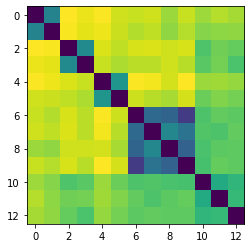

In [11]:
D = synth_data[0]
plt.figure()
plt.imshow(pairwise_distances(D.M.T))
plt.show()
plt.close()

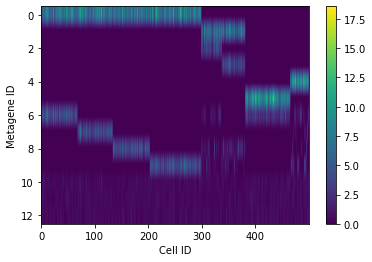

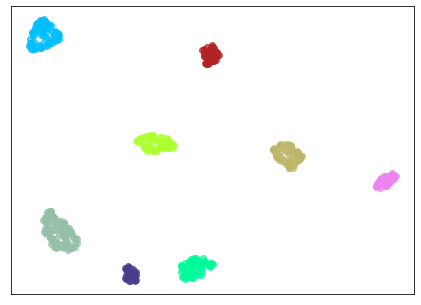

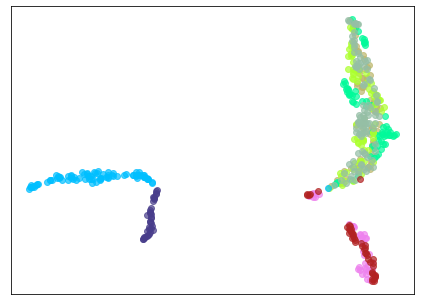

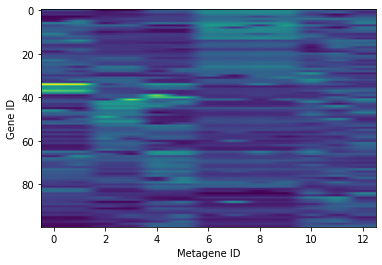

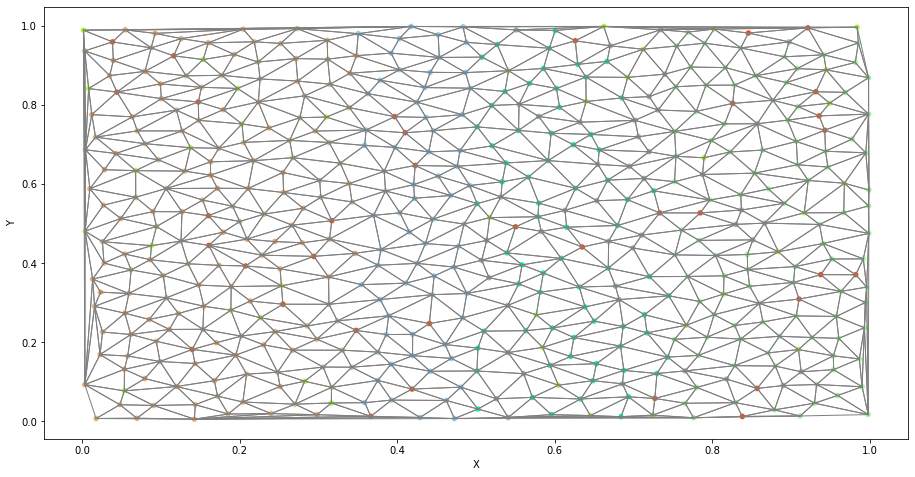

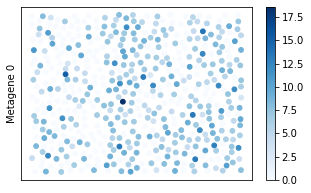

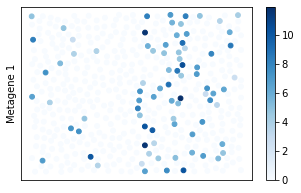

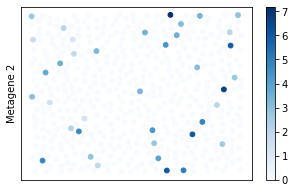

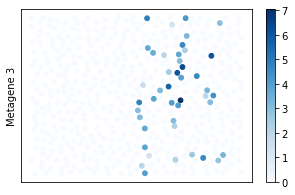

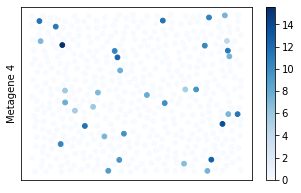

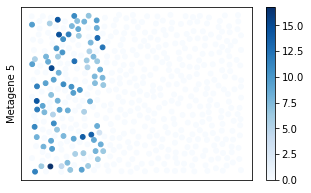

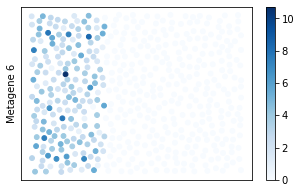

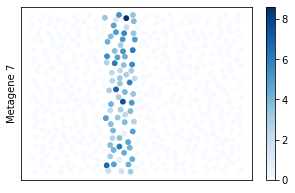

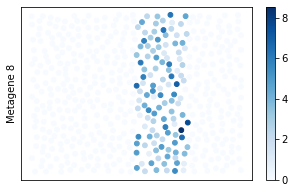

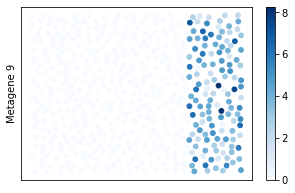

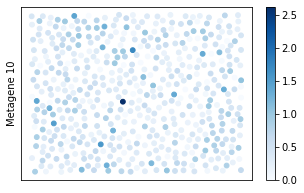

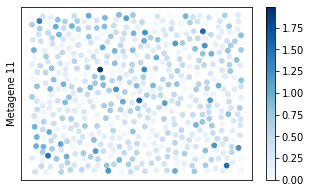

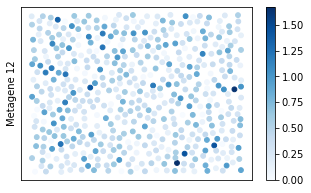

In [9]:
D = synth_data[0]
D.plot_hidden_states()
D.plot_latent_space()
D.plot_expression_space()
D.plot_metagenes()
D.plot_cell_types()
D.plot_metagenes_in_situ()